In [1]:
global n
n = 3
epochs = 1
supervisionEpochs = 2
lr1 = 0.01
lr2 = 0.0001
log_interval = 10
trainSize = 50000#100000
percentage_train_test= 0.4
penaltyLambda = 10
dpPrecision=50
pdfPrecision=100
init_weights="xavier_normal"#"kaiming_uniform""kaiming_normal""xavier_uniform"

In [2]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset
from pylab import *
from scipy.stats import beta
import math
from localfiles import mydistribution
global samplesJoint,tp_dataloader,tp_dataloader_testing,dp,decision,dp_H,decision_H
global decision_offer,decision_welfare,record_ans

In [3]:
stage=["twopeak"]
# "twopeak","normal","uniform","independent1","independent2","cauchy","beta","U-exponential","arcsine"
order1name=["dp","random initializing","costsharing"]
#order1name=["random initializing1","random initializing2","random initializing3"]
# "costsharing","dp","heuristic","random initializing"

In [4]:
print(mydistribution)
mydistribution.inital(n)

<module 'localfiles.mydistribution' from 'D:\\coding\\jupyter workplace\\Mechanism Design\\Public Good\\Excluable public good max welfare\\localfiles\\mydistribution.py'>
0.3540388371733616


In [5]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [6]:
global record_ans
record_ans=0
def recordAndReport(name, source, loss):
    source.append(loss)
    realLength = len(source)
    #print(f"{name} ({realLength}): {loss}")
    print(name,realLength,":" ,loss)

In [7]:
def bitsToPayments(bits):
    if torch.sum(bits).item() == 0:
        return torch.ones(n)
    bits     = bits.type(torch.float32)
    negBits  = torch.ones(n) - bits
    payments = model(bits)
    payments = payments - 1000 * negBits
    payments = torch.softmax(payments, 0)
    payments = payments + negBits
    return payments

def tpToBits(tp, bits=torch.ones(n).type(torch.uint8)):
    payments = bitsToPayments(bits)
    newBits = (tp >= payments).type(torch.uint8)
    if torch.equal(newBits, bits):
        return bits
    else:
        return tpToBits(tp, newBits)#bits-bits#tpToBits(tp, newBits)

def tpToPayments(tp):
    return bitsToPayments(tpToBits(tp))


def tpToTotalWelfare(tp):
    return torch.max(torch.tensor(0.0),torch.dot(tp,tpToBits(tp).type(torch.float32))-1.0)


In [8]:
def dpSupervisionRule(tp):
    global decision_offer,decision_welfare
    global record_ans
    global  dp,decision
    tp = list(tp.numpy())
    bits = [1 for ii in range(n)]
    payments = [0.0 for ii in range(n)]
    money = dpPrecision
    record_=0
    for i in range(n):
        offerIndex = decision_offer[n - i, money,record_]
        offer = float(offerIndex) / dpPrecision
        if tp[i] > offer:
            money -= offerIndex
            bits[i] = 1
            record_ = decision_welfare[n - i, money, record_]
            payments[i] = offer
        else:
            bits[i] = 0
            payments[i] = 1
    if money > 0:
        bits = [0 for ii in range(n)]
        payments = [1.0 for ii in range(n)]
    bits = torch.tensor(bits, dtype=torch.uint8)
    payments = torch.tensor(payments, dtype=torch.float32)
#     print()
#     print(tp)
#     print(bits)
#     print(payments)
#     print()
    return (bits, payments)


def heuristicSupervisionRule(tp):
    global  dp_H,decision_H
    tp = list(tp.numpy())
    bits = [1 for ii in range(n)]
    payments = [0.0 for ii in range(n)]
    tempold=-1;
    for turns in range(n,0,-1):
        money = dpPrecision
        j=0
        tempo=sum(bits)
        #print("bits",tempo)
        for i in range(n):
            if(j>=n):
                break;
            
            offerIndex = decision_H[tempo ,tempo - i, money]
            offer = float(offerIndex) / dpPrecision
            while(j<n):
                if(bits[j]!=0):
                    break;
                j+=1;
            if(j>=n):
                break;
            if tp[j] >= offer:
                #print(money,j,tp[j],offer)
                money -= offerIndex
                bits[j] = 1
                payments[j] = offer
            else:
                bits[j] = 0;
                payments[j] = 1.0;
            j+=1;
        #print("money",money)
        if(money==0 and tempold==tempo):
            break;
        tempold=tempo;
    if money > 0:
        bits = [0 for ii in range(n)]
        payments = [1.0 for ii in range(n)]

    bits = torch.tensor(bits, dtype=torch.float32)
    payments = torch.tensor(payments, dtype=torch.float32)
    # print()
    # print(tp)
    # print(bits)
    # print(payments)
    # print()
    return (bits, payments)



def costSharingSupervisionRule(tp):
    tp = list(tp.numpy())
    for k in range(n, -1, -1):
        if k == 0:
            break
        bits = [1 if tp[ii] >= 1.0 / k else 0 for ii in range(n)]
        if sum(bits) == k:
            break
    if k == 0:
        bits = [0 for ii in range(n)]
        payments = [1 for ii in range(n)]
    else:
        payments = [1.0 / k if bits[ii] == 1 else 1 for ii in range(n)]
    bits = torch.tensor(bits, dtype=torch.uint8)
    payments = torch.tensor(payments, dtype=torch.float32)
    return (bits, payments)

    
def costSharingWelfare(tp):
    #print(tp,costSharingSupervisionRule(tp)[0])
    return max(0.0,float(torch.dot(tp,torch.tensor(costSharingSupervisionRule(tp)[0],dtype=torch.float32)).item()-1.0))

def dpWelfare(tp):
    return max(0.0,float(torch.dot(tp,torch.tensor(dpSupervisionRule(tp)[0],dtype=torch.float32)).item()-1.0))

def heuristicWelfare(tp):
    return max(0.0,float(torch.dot(tp,torch.tensor(heuristicSupervisionRule(tp)[0],dtype=torch.float32)).item()-1.0))


In [9]:

def supervisionTrain(epoch, supervisionRule):
    model.train()
    for batch_idx, (tp_batch,) in enumerate(tp_dataloader):
        optimizer.zero_grad()
        penalty = 0
        for bitsMoreOnes in allBits:
            for i in range(n):
                if bitsMoreOnes[i] == 1:
                    bitsLessOnes = bitsMoreOnes.clone()
                    bitsLessOnes[i] = 0
                    
                    penalty = penalty + torch.sum(
                        torch.relu(
                            bitsToPayments(bitsMoreOnes) - bitsToPayments(bitsLessOnes)
                        )
                    )
        loss = penalty * penaltyLambda /100000
        
        for tp in tp_batch:
            bits, payments = supervisionRule(tp)
            loss = loss + F.mse_loss(bitsToPayments(bits), payments)

        loss = loss / len(tp_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(tp_batch),
                    len(tp_dataloader.dataset),
                    100.0 * batch_idx / len(tp_dataloader),
                    loss.item(),
                )
            )

losslist=[];
losslistname=[];
losslisttemp=[];
def test_batch():
    global losslisttemp; 
    model.eval()
    with torch.no_grad():
        lenLoss= 0
        nnLoss = 0
        for (tp_batch,) in tp_dataloader_testing:
            for tp in tp_batch:
                nnLoss += tpToTotalWelfare(tp)
            lenLoss+=len(tp_batch)
        nnLoss/=lenLoss
    return nnLoss


def train(epoch):
    global record_ans
    global losslisttemp; 
    model.train()
    for batch_idx, (tp_batch,) in enumerate(tp_dataloader):
        optimizer.zero_grad()
        loss=0;
        for tp in tp_batch:
            for i in range(n):
                tp1 = tp.clone()
                tp1[i] = 1
                tp0 = tp.clone()
                tp0[i] = 0
                offer = tpToPayments(tp1)[i]
                Welfare1 = tpToTotalWelfare(tp1)
                Welfare0 = tpToTotalWelfare(tp0)
                if(order!="independent1" and order!="independent2"):
                    loss = loss + (1 - mydistribution.cdf(offer,order)) * Welfare1 + mydistribution.cdf(offer,order) * Welfare0
                else:
                    loss = loss + (1 - mydistribution.cdf(offer,order,i)) * Welfare1 + mydistribution.cdf(offer,order,i) * Welfare0

        loss = -loss / len(tp_batch) / n
        
        penalty = 0
        for bitsMoreOnes in allBits:
            for i in range(n):
                if bitsMoreOnes[i] == 1:
                    bitsLessOnes = bitsMoreOnes.clone()
                    bitsLessOnes[i] = 0
                    penalty = penalty + torch.sum(
                        torch.relu(
                            bitsToPayments(bitsMoreOnes) - bitsToPayments(bitsLessOnes)
                        )
                    )
        loss += penalty * penaltyLambda
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            losstemp=test_batch();
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(tp_batch),
                    len(tp_dataloader.dataset),
                    100.0 * batch_idx / len(tp_dataloader),
                    loss.item(),
                ),"testing loss:",losstemp
            )
            losslisttemp.append(losstemp);
            
    print("penalty:",penalty.item())
    
allBits = [torch.tensor(bits, dtype=torch.int16) for bits in itertools.product([0, 1], repeat=n)]

def test():
    global record_ans
    global losslisttemp; 
    model.eval()

    with torch.no_grad():
        costSharingLoss = 0
        dpLoss = 0
        nnLoss = 0
        heuristicLoss=0
        lenLoss= 0
        for (tp_batch,) in tp_dataloader_testing:

            for tp in tp_batch:
                costSharingLoss += costSharingWelfare(tp)
                dpLoss += dpWelfare(tp)
                nnLoss += tpToTotalWelfare(tp)
                heuristicLoss+= heuristicWelfare(tp)
            lenLoss+=len(tp_batch)
        costSharingLoss /= lenLoss
        dpLoss /= lenLoss
        nnLoss /= lenLoss
        heuristicLoss /= lenLoss
        #print(lenLoss)
        losslisttemp.append(nnLoss);
        recordAndReport("NN", runningLossNN, nnLoss)
        recordAndReport("CS", runningLossCS, costSharingLoss)
        recordAndReport("DP", runningLossDP, dpLoss)
        recordAndReport("heuristic", runningLossHeuristic, heuristicLoss)
        print("DP:",dp[n, dpPrecision,0])
        #for i in range(n, 0, -1):
        #    print("Heuristic:",i,5*(1-dp_H[i, i, dpPrecision]))
        for i in range(n, 0, -1):
            print(
                    tpToPayments(
                            torch.tensor([0 if ii >= i else 1 for ii in range(n)], dtype=torch.float32)
                    )
                )
            


In [10]:
def run_dp():
    global decision_offer,decision_welfare,decision_H
    global dp,dp_H,record_ans
    pdfnumber=[0 for i in range(pdfPrecision+1)];
    cdfnumber=[0 for i in range(pdfPrecision+1)];
    utilitynumber=[0 for i in range(pdfPrecision+1)];
    Possible_utility=[0 for i in range(pdfPrecision+1)];
    for i in range(int(trainSize * percentage_train_test)):
        for j in range(n):
            pdfnumber[int(samplesJoint[i,j]*pdfPrecision)]+=1.0/int(trainSize * percentage_train_test*n)
    cdfnumber[0]=pdfnumber[0];
    for i in range(1,pdfPrecision+1):
        cdfnumber[i]=cdfnumber[i-1]+pdfnumber[i]
    #print(cdfnumber)  
    for i in range(1,pdfPrecision+1):
        cdfnumber[i]=cdfnumber[i-1]+pdfnumber[i]   
    for i in range(0,pdfPrecision+1):
        utilitynumber[i]=0
        for j in range(i,pdfPrecision+1):
            utilitynumber[i]+=pdfnumber[j]*float(j-i)/pdfPrecision
        if(sum(pdfnumber[i:])!=0):
            utilitynumber[i]/=sum(pdfnumber[i:])
    plt.plot(pdfnumber)
    plt.show()
    print(sum(pdfnumber))

    plt.plot(utilitynumber)
    plt.show()
    
    
    # howManyPpl left, money left, yes already
    dp        = np.zeros([n + 1, dpPrecision + 1, dpPrecision*n + 1])
    decision_offer = np.zeros([n + 1, dpPrecision + 1, dpPrecision*n + 1], dtype=np.uint8)
    decision_welfare = np.zeros([n + 1, dpPrecision + 1, dpPrecision*n + 1], dtype=np.uint8)
    for yes in range(dpPrecision*n + 1):
        for money in range(dpPrecision + 1):
                offer = float(money) / dpPrecision                                                                     
                dp[1, money, yes] =(1.0 - mydistribution.cdf(offer,order).item()) * (yes/dpPrecision + utilitynumber[round(offer*pdfPrecision)])
                decision_offer[1, money, yes] = money
                decision_welfare[1, money, yes] = int(yes + utilitynumber[round(offer*pdfPrecision)]*dpPrecision)
    for ppl in range(2,  n + 1):
        for yes in range(dpPrecision*n + 1):
            for money in range(dpPrecision + 1):
                maxSoFar = -100000
                for offerIndex in range(money + 1):
                    offer = float(offerIndex) / dpPrecision
                    if(order!="independent1" and order!="independent2"):
                        yes_old = int(yes+round(utilitynumber[round(offer*pdfPrecision)]*dpPrecision))
                        
                        res = (1 - mydistribution.cdf(offer,order)) * dp[
                        ppl - 1, money - offerIndex, min(yes_old, dpPrecision*n)
                        ] + mydistribution.cdf(offer,order) * (dp[ppl - 1, money, yes])
                    else:
                        yes_old = int(yes+round(utilitynumber[round(offer*pdfPrecision)]*dpPrecision))
                        res = (1 - mydistribution.cdf(offer,order,n-ppl).item()) * dp[
                        ppl - 1, money - offerIndex, min(yes_old, dpPrecision*n)
                        ] + mydistribution.cdf(offer,order,n-ppl).item() * (dp[ppl - 1, money, yes])
                    if maxSoFar < res:
                        maxSoFar = res
                        decision_offer[ppl, money, yes] = offerIndex
                        decision_welfare[ppl, money, yes] = yes_old
                dp[ppl, money, yes] = maxSoFar
    
    print("dp",dp[n, dpPrecision, 0])
    
    def verify_dp(temp,debug):
        if(debug==1):
            print(temp)
        ans =0;
        o_list=[];
        remain_list=[];
        remain=dpPrecision
        record_= 0
        for ppl in range(n,0,-1):
            o=decision_offer[ppl, remain, record_]
            
            #print("record",o,record_)
            if(debug==1):
                print(o,remain,record_)
            o_list.append(o)
            remain_list.append(remain);
            if(o<temp[n-ppl]):
                remain-=int(o);
                record_=decision_welfare[ppl, remain, record_]
                ans=1#+=float(temp[n-ppl]-o)/dpPrecision
                #print("record",record_)
            elif (remain>0):
                ans=0;
        if(remain<=1):
            return ans,o_list;
        else:
            return 0,o_list;
    ans_list=[];
    for i in range(5):
        temp=samplesJoint[i]*dpPrecision
        #print(temp)
        tempres=verify_dp(temp,1)
        ans_list.append(tempres[0]);
        print(tempres)
        #print("\n",temp)
        #print(plan_dp(temp,1))

    for i in range(10000):
        temp=samplesJoint[i]*dpPrecision
        #print(temp)
        ans_list.append(verify_dp(temp,0)[0]);
        #print("\n",temp)
        #print(plan_dp(temp))
    print("verify dp vaule:",sum(ans_list)/len(ans_list))
    
    # howManyPpl left, money left, yes already
    dp_H = np.zeros([n + 1 , n + 1, dpPrecision + 1])
    decision_H = np.zeros([n + 1 , n + 1, dpPrecision + 1], dtype=np.uint8)
    # ppl = 0 left
    for i in range(1,n+1):
        for money in range(dpPrecision + 1):
            if money == 0:
                dp_H[i, 0, 0] = 1
            else:
                offer = money / dpPrecision
                dp_H[i, 0, money] = 0#mydistribution.cdf(offer)# + 1.0
    for i in range(1,n+1):
        for ppl in range(1, i + 1):
            for money in range(dpPrecision + 1):
                maxSoFar = -1000000
                for offerIndex in range(money + 1):
                    offer = float(offerIndex) / dpPrecision
                    if(order!="independent1" and order!="independent2"):
                        res = (1-mydistribution.cdf(offer,order)) * dp_H[
                         i, ppl - 1, money - offerIndex
                        ]
                    else:
                        res = (1-mydistribution.cdf(offer,order,ppl-1)) * dp_H[
                         i, ppl - 1, money - offerIndex
                        ]
                    if maxSoFar < res.item():
                        maxSoFar = res.item()
                        decision_H[i, ppl, money] = offerIndex
                dp_H[i, ppl, money] = maxSoFar
                
        


In [11]:
def init_weights_xavier_uniform(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)
        
def init_weights_xavier_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.1)
        
        
def init_weights_kaiming_uniform(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.1)
        
        
def init_weights_kaiming_normal_(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.1)

loc 0.2 scale 0.05
loc 0.4 scale 0.05


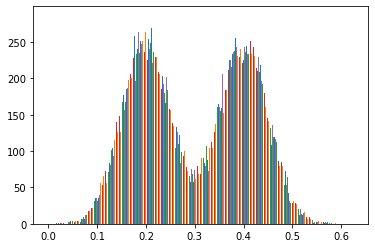

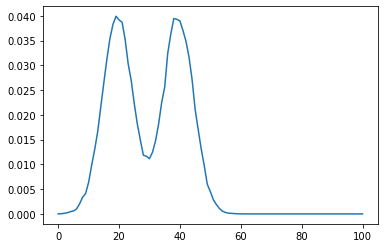

0.9999999999999946


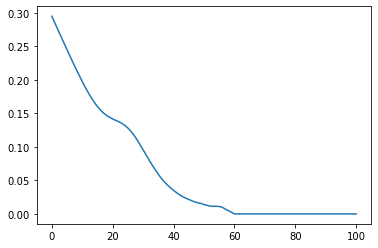

dp 0.2631515860557556
[16.36588508 19.41970698 10.18474349 17.50956334 19.64305966]
16 50 0
10 34 8
8 24 16
8 16 25
8 8 36
(1, [16, 10, 8, 8, 8])
[ 9.67926219 18.85572079 20.14171658 19.32285845  8.61055527]
16 50 0
16 50 0
16 34 7
10 18 15
8 8 26
(1, [16, 16, 16, 10, 8])
[10.45111151 17.63545209 17.38604168 17.58136851  9.43708327]
16 50 0
16 50 0
16 34 7
10 18 15
8 8 26
(1, [16, 16, 16, 10, 8])
[19.98440963 25.18966292 19.40195579  6.14124753  9.23786854]
16 50 0
10 34 8
8 24 16
8 16 25
16 16 25
(0, [16, 10, 8, 8, 16])
[18.11086798 19.18400831 23.27104001 22.29897858 12.55465567]
16 50 0
10 34 8
8 24 16
8 16 25
8 8 36
(1, [16, 10, 8, 8, 8])
verify dp vaule: 0.48195902048975514
Supervised Aim: twopeak dp
Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=5, bias=T

D:\ComputerSoftwares\Anaconda\lib\site-packages\ipykernel_launcher.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\ComputerSoftwares\Anaconda\lib\site-packages\ipykernel_launcher.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\ComputerSoftwares\Anaconda\lib\site-packages\ipykernel_launcher.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


NN 1 : tensor(0.2761)
CS 1 : 0.2773620503604412
DP 1 : 0.2682859631717205
heuristic 1 : 0.2662026878476143
DP: 0.2631515860557556
tensor([0.3200, 0.2000, 0.1600, 0.1600, 0.1600])
tensor([0.3816, 0.2140, 0.1995, 0.2048, 1.0000])
tensor([0.4605, 0.2846, 0.2548, 1.0000, 1.0000])
tensor([0.6096, 0.3904, 1.0000, 1.0000, 1.0000])
tensor([1., 1., 1., 1., 1.])
Train Epoch: 1 [0/20000 (0%)]	Loss: -0.550062 testing loss: tensor(0.2759)
Train Epoch: 1 [2560/20000 (13%)]	Loss: -0.624349 testing loss: tensor(0.2761)
Train Epoch: 1 [5120/20000 (25%)]	Loss: -0.570018 testing loss: tensor(0.2767)
Train Epoch: 1 [7680/20000 (38%)]	Loss: -0.561995 testing loss: tensor(0.2771)
Train Epoch: 1 [10240/20000 (51%)]	Loss: -0.570341 testing loss: tensor(0.2773)
Train Epoch: 1 [12800/20000 (64%)]	Loss: -0.578923 testing loss: tensor(0.2778)
Train Epoch: 1 [15360/20000 (76%)]	Loss: -0.565831 testing loss: tensor(0.2780)
Train Epoch: 1 [17920/20000 (89%)]	Loss: -0.537609 testing loss: tensor(0.2784)
penalty: 0.0


In [12]:

for order in stage:
    samplesJoint=mydistribution.producedata(order,trainSize)
    tp_tensor = torch.tensor(samplesJoint, dtype=torch.float32)
    tp_dataset = TensorDataset(tp_tensor[: int(trainSize * percentage_train_test)])
    tp_dataset_testing = TensorDataset(tp_tensor[int(trainSize * (1.0-percentage_train_test)) :])
    tp_dataloader = DataLoader(tp_dataset, batch_size=128, shuffle=True)
    tp_dataloader_testing = DataLoader(tp_dataset_testing, batch_size=256, shuffle=False)
    run_dp()
    #running
    for order1 in order1name:
        print("Supervised Aim:",order,order1)
        
        # Instantiate the model with hyperparameters
        model = nn.Sequential(
            nn.Linear(n, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n),
        )
        if(init_weights=="xavier_uniform"):
            model.apply(init_weights_xavier_uniform)
        if(init_weights=="xavier_normal"):
            model.apply(init_weights_xavier_normal)
        if(init_weights=="kaiming_uniform"):
            model.apply(init_weights_xavier_uniform)
        if(init_weights=="kaiming_normal"):
            model.apply(init_weights_xavier_normal)
        # optimizer = optim.SGD(model.parameters(), lr=lr)
        optimizer = optim.Adam(model.parameters(), lr=lr1)
        print(model)
        
        runningLossNN = []
        runningLossCS = []
        runningLossDP = []
        runningLossHeuristic = []
        #model=torch.load("save/pytorchNN=5dp1");
        #model.eval()
        ##order1name=["costsharing","dp","heuristic","random initializing"]
        for epoch in range(1, supervisionEpochs + 1):
#             print("distributionRatio",distributionRatio)
            if(order1=="costsharing"):
                supervisionTrain(epoch, costSharingSupervisionRule)
            elif(order1=="dp"):
                supervisionTrain(epoch, dpSupervisionRule)
            elif(order1=="heuristic"):
                supervisionTrain(epoch, heuristicSupervisionRule)
            elif(order1=="random initializing"):
                print("do nothing");

        test()
        optimizer = optim.Adam(model.parameters(), lr=lr2)
        for epoch in range(1, epochs + 1):
            train(epoch)
            test()
        losslistname.append(order+" "+order1);
        losslist.append(losslisttemp);
        losslisttemp=[];
        savepath="save/pytorchNN=5all-beta"+order+str(order1)
        torch.save(model, savepath);
        print("end")
        print()

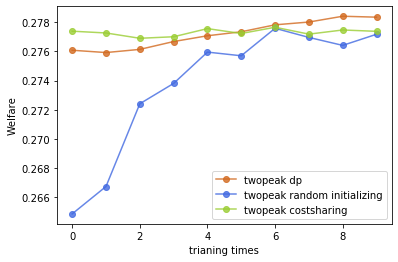

In [13]:
colorlist=["#D2691E",'#4169E1',"#9ACD32","#B22222","#FF00FF","#708090"]
for i in range(len(losslist)):
    plt.plot(losslist[i], 'ro-', color=colorlist[i], alpha=0.8, label=losslistname[i])

# 显示标签，如果不加这句，即使加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="best")
plt.xlabel('trianing times')
plt.ylabel('Welfare')

plt.show()